In [1]:
import datetime
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timestamp as ts
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
Path.cwd()

PosixPath('/Users/jwt/PycharmProjects/cpi_program/WDBA2023')

In [4]:
today = datetime.datetime.today()
input_file = Path.cwd() / 'data_files' / 'wdba_stats_processed_2022_2023Jun-04-23.csv'
report_dir = Path.cwd() / 'reports'
report_file = report_dir / f"WDBA_Stats_{today:%b-%d-%y}.xlsx"


In [5]:
# Helper function to annualize projections
def annualized_projection(value: int, num_months: int) -> int:
    """
    Annualize projections given a value and elapsed months

    Parameters
    ----------
    value : int
        Value to be annualized
    num_months : int
        Number of months elapsed
    """
    return int(round(value * (12 / num_months), 0))

In [275]:
df = pd.read_csv(input_file, parse_dates=['date_filed', "date_reopened", "date_terminated"],
                 dtype={'group': 'category', 'is_prose': 'category'})

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4784 entries, 0 to 4783
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   case_number       4784 non-null   object        
 1   judge             4784 non-null   object        
 2   date_filed        4784 non-null   datetime64[ns]
 3   date_reopened     87 non-null     datetime64[ns]
 4   date_terminated   4136 non-null   datetime64[ns]
 5   NOS               4784 non-null   int64         
 6   IsProse           4784 non-null   object        
 7   group             4784 non-null   category      
 8   is_prose          4784 non-null   category      
 9   statistical_year  4784 non-null   int64         
dtypes: category(2), datetime64[ns](3), int64(2), object(3)
memory usage: 309.3+ KB


In [277]:
df.head()

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
0,3:18-cv-00232-bbc,bbc,2018-04-02,NaT,2018-05-02,550,y,Prisoner Petitions,prose,2019
1,3:18-cv-00231-jdp,jdp,2018-04-02,NaT,2019-02-21,440,y,Civil Rights,prose,2019
2,3:18-cv-00234-jdp,jdp,2018-04-02,NaT,2018-04-23,530,y,Habeas Corpus,prose,2019
3,3:18-cv-00233-bbc,bbc,2018-04-03,NaT,2018-07-18,864,n,Social Security,counseled,2019
4,3:18-cv-00235-wmc,wmc,2018-04-04,NaT,2019-09-25,791,y,Labor,prose,2019


In [278]:
df.tail()

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
4779,3:17-cv-00435-wmc,wmc,2017-06-05,2021-04-08,2022-06-22,540,n,Prisoner Petitions,counseled,2022
4780,3:17-cv-00552-wmc,wmc,2017-07-17,2021-05-06,2022-08-18,550,y,Prisoner Petitions,prose,2022
4781,3:17-cv-00231-bbc,bbc,2017-03-22,2021-06-02,2021-06-02,530,n,Habeas Corpus,counseled,2022
4782,3:17-cv-00524-wmc,wmc,2017-07-06,2021-07-08,2022-04-28,550,y,Prisoner Petitions,prose,2022
4783,3:16-cv-00229-wmc,wmc,2016-04-11,2021-10-04,NaT,530,y,Habeas Corpus,prose,2022


In [10]:
case_breakdown_pro_se_vs_counseled = df.groupby(['statistical_year', 'is_prose'])['case_number'].count()

In [11]:
case_breakdown_pro_se_vs_counseled.unstack()

is_prose,counseled,prose
statistical_year,,
2022,473,354
2023,419,378


In [12]:
pd.crosstab(df['statistical_year'],
            df['is_prose'],
            aggfunc='count',
            values=df['case_number'],
            margins=True,
            margins_name='Total',
            normalize='index')

is_prose,counseled,prose
statistical_year,,
2022,0.571947,0.428053
2023,0.525721,0.474279
Total,0.549261,0.450739


In [13]:
pd.pivot_table(df,
               index=['statistical_year'],
               columns=['is_prose'],
               values=['case_number'],
               aggfunc='count',
               margins=True,
               margins_name='Total',
               fill_value=0,
               dropna=False,
               observed=False)

case_number            
is_prose           counseled prose Total
statistical_year                        
2022                     473   354   827
2023                     419   378   797
Total                    892   732  1624

In [279]:
df['group'] = df['group'].apply(lambda x: 'Prisoner Petitions' if x == 'Habeas Corpus' else x)
df['group'] = df['group'].apply(lambda x: 'Torts/Personal Injury' if x == 'Personal Property' else x)

In [280]:
nos_totals_by_year = pd.crosstab(df['group'],
                                 df['statistical_year'],
                                 aggfunc='count',
                                 values=df['case_number'],
                                 margins=True,
                                 margins_name='Total')

In [16]:
# Annualize projections for 2023
# nos_totals_by_year.loc[2023,:] = nos_totals_by_year.loc[2023,:].apply(lambda x: annualized_projection(x, 11))

In [282]:
nos_totals_by_year

statistical_year,2019,2020,2021,2022,2023,Total
group,,,,,,
Bankruptcy,4.0,4.0,4.0,5.0,4.0,21
Civil Rights,134.0,135.0,135.0,133.0,145.0,682
Contract,58.0,71.0,53.0,52.0,49.0,283
Federal Tax Suits,11.0,6.0,2.0,3.0,7.0,29
Forfeiture/Penalty,4.0,4.0,7.0,5.0,7.0,27
Immigration,2.0,2.0,NaN,8.0,9.0,21
Intellectual Property Rights,44.0,49.0,36.0,29.0,28.0,186
Labor,75.0,69.0,64.0,51.0,51.0,310
Other Statutes,118.0,137.0,146.0,88.0,46.0,535


In [283]:
nos_totals_by_year = pd.crosstab(df['group'],
                                 df['statistical_year'],
                                 aggfunc='count',
                                 values=df['case_number'],
                                 margins=False)

In [291]:
nos_totals_by_year  = nos_totals_by_year.loc[:, [2020,2023]]

In [20]:
pct_change = nos_totals_by_year.pct_change(axis='columns')

In [21]:
pct_change

statistical_year,2022,2023
group,,
Bankruptcy,NaN,-0.200000
Civil Rights,NaN,0.089552
Contract,NaN,-0.075472
Federal Tax Suits,NaN,1.333333
Forfeiture/Penalty,NaN,0.400000
Immigration,NaN,0.125000
Intellectual Property Rights,NaN,0.068966
Labor,NaN,0.000000
Other Statutes,NaN,-0.483146


In [22]:
round(pct_change.loc[:, 2023] * 100, 2)

group
Bankruptcy                      -20.00
Civil Rights                      8.96
Contract                         -7.55
Federal Tax Suits               133.33
Forfeiture/Penalty               40.00
Immigration                      12.50
Intellectual Property Rights      6.90
Labor                             0.00
Other Statutes                  -48.31
Prisoner Petitions               -1.39
Real Property                   160.00
Social Security                  14.46
Torts/Personal Injury           -25.68
Name: 2023, dtype: float64

In [23]:
pct_change[2023].values



array([-0.2       ,  0.08955224, -0.0754717 ,  1.33333333,  0.4       ,
        0.125     ,  0.06896552,  0.        , -0.48314607, -0.01388889,
        1.6       ,  0.14457831, -0.25675676])

In [24]:
stats = pd.read_csv('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/data_files/wdba_stats_processed_Jun-05-23.csv',
                    parse_dates=['date_filed', "date_reopened", "date_terminated"],
                    dtype={'group': 'category', 'is_prose': 'category'})

In [25]:
total_cases = pd.pivot_table(stats, index=['statistical_year'], aggfunc='count', values=['case_number'])

In [26]:
stats.tail()

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
4779,3:17-cv-00435-wmc,wmc,2017-06-05,2021-04-08,2022-06-22,540,n,Prisoner Petitions,counseled,2022
4780,3:17-cv-00552-wmc,wmc,2017-07-17,2021-05-06,2022-08-18,550,y,Prisoner Petitions,prose,2022
4781,3:17-cv-00231-bbc,bbc,2017-03-22,2021-06-02,2021-06-02,530,n,Habeas Corpus,counseled,2022
4782,3:17-cv-00524-wmc,wmc,2017-07-06,2021-07-08,2022-04-28,550,y,Prisoner Petitions,prose,2022
4783,3:16-cv-00229-wmc,wmc,2016-04-11,2021-10-04,NaT,530,y,Habeas Corpus,prose,2022


In [27]:
total_cases

,case_number
statistical_year,
2019,1066
2020,1104
2021,1028
2022,807
2023,779


## Plots


In [130]:
# Colorblind-friendly colors
colors = [[0, 0, 0], [230 / 255, 159 / 255, 0], [86 / 255, 180 / 255, 233 / 255], [0, 158 / 255, 115 / 255],
          [213 / 255, 94 / 255, 0], [0, 114 / 255, 178 / 255]]


In [29]:
x = total_cases['case_number']
y = total_cases.index

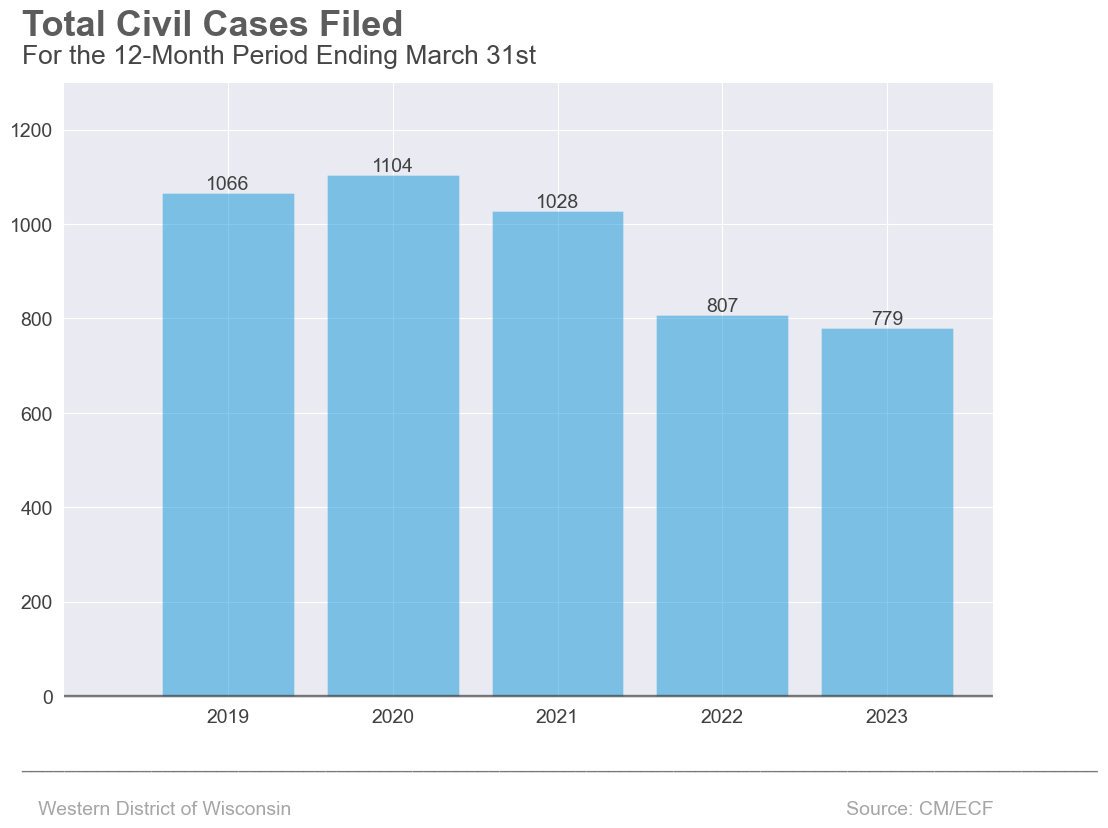

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
style.use('fivethirtyeight')
bar_width = 0.8
for (total, year) in zip(x, y):
    p = ax.bar(year,
               # using the Case ID data
               total,
               # set the width
               width=bar_width,
               # with the label Case Year
               label=year,
               # with alpha 0.5
               alpha=0.5,
               # with color
               color='#0F95D7')
    ax.bar_label(p, label_type='edge', fontsize=14, color='#414141')
# Y axis past 0 & above 100 -- grid line will pass 0 & 100 marker
plt.ylim(-5, 1300)
# Bolded horizontal line at y=0
ax.axhline(y=0, color='#414141', linewidth=1.7, alpha=.7)

# Y-labels to only these
ax.set_yticks([0, 200, 400, 600, 800, 1000, 1200])
ax.set_yticklabels(labels=['0', '200', '400', '600', '800', '1000', '1200'], fontsize=14, color='#414141')

# X-labels and changing label names
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.set_xticklabels(['2019', '2020', '2021', '2022', '2023'], fontsize=14, color='#414141')

# create more vertical space
plt.xlim(left=2018)

# Title and Subtitle
ax.text(x=2017.75, y=1400, s="Total Civil Cases Filed", fontsize=26, weight='bold', alpha=.75)
ax.text(x=2017.75, y=1340, s="For the 12-Month Period Ending March 31st", fontsize=19, alpha=.85)

# Signature bar
ax.text(x=2017.75, y=-150,
        s='___________________________________________________________________________________________________',
        color='#414141', alpha=.7)
# Footer
ax.text(x=2017.75, y=-250,
        s='   Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)

ax.text(x=2022.65, y=-250,
        s='   Source: CM/ECF', fontsize=14, color='grey', alpha=.7);

plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/total_cases.png', dpi=300, bbox_inches='tight', transparent=False)

In [294]:
nos_totals_by_year.pct_change(axis='columns').mul(100).round(2)


statistical_year,2020,2023
group,,
Bankruptcy,NaN,0.00
Civil Rights,NaN,7.41
Contract,NaN,-30.99
Federal Tax Suits,NaN,16.67
Forfeiture/Penalty,NaN,75.00
Immigration,NaN,350.00
Intellectual Property Rights,NaN,-42.86
Labor,NaN,-26.09
Other Statutes,NaN,-66.42


In [32]:
p = round(pct_change.loc[:, 2023] * 100, 2)
p.values


array([-20.  ,   8.96,  -7.55, 133.33,  40.  ,  12.5 ,   6.9 ,   0.  ,
       -48.31,  -1.39, 160.  ,  14.46, -25.68])

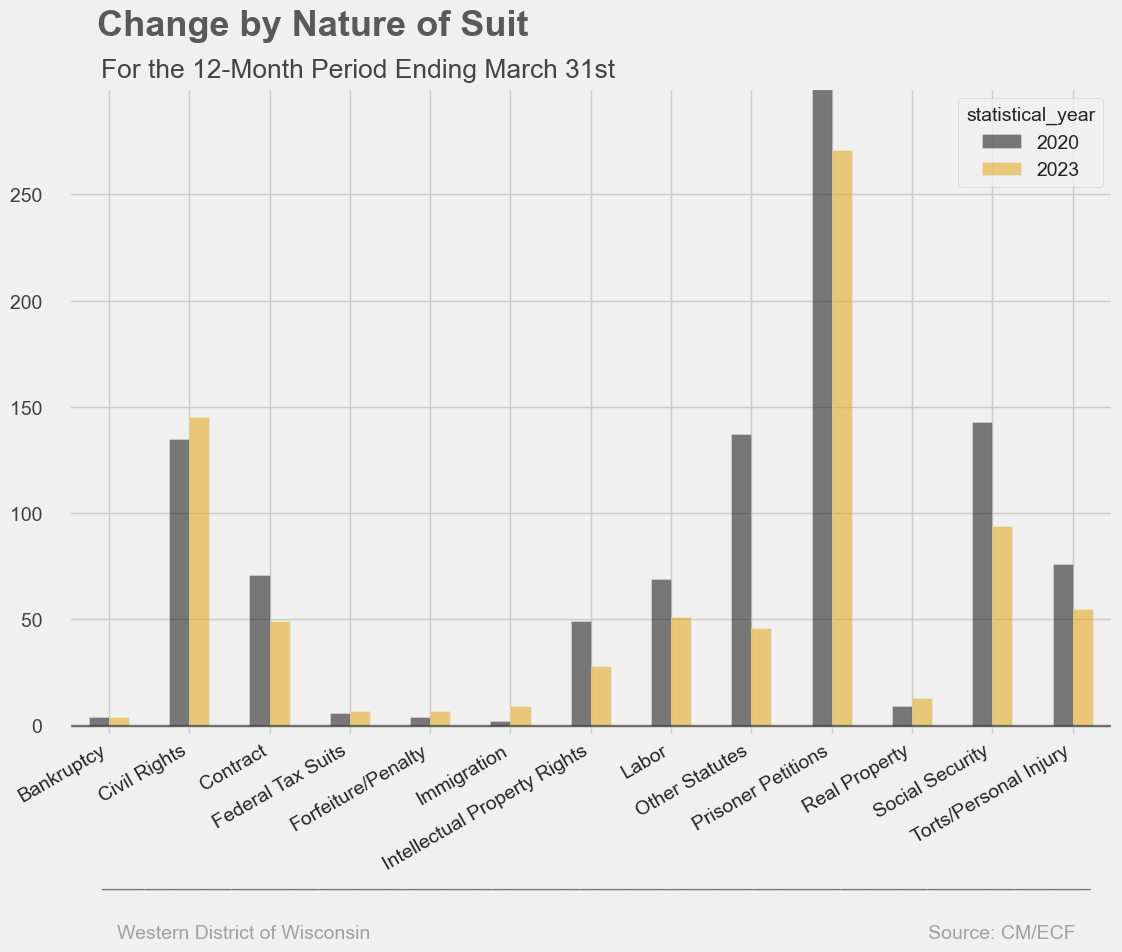

In [292]:
fte_graph = nos_totals_by_year.plot(kind='bar',
                                    figsize=(12, 8),
                                    alpha=0.5,
                                    color=colors)
ax = plt.gca()
fig = plt.gcf()
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.xticks(rotation=30, horizontalalignment="right")
plt.ylim(-5, 300)

ax.axhline(y=0, color='#414141', linewidth=1.7, alpha=.7)
ax.xaxis.label.set_visible(False)

# Y-labels to only these
ax.set_yticks([0, 50, 100, 150, 200, 250])
ax.set_yticklabels(labels=['0    ','50    ', '100    ', '150    ','200    ','250    ' ], fontsize=14, color='#414141')

# Title and Subtitle
ax.text(x=-.15, y=325, s="Change by Nature of Suit", fontsize=26, weight='bold', alpha=.75)
ax.text(x=-.1, y=305, s="For the 12-Month Period Ending March 31st", fontsize=19, alpha=.85)

# Signature bar
ax.text(x=-.1, y=-75,
        s='___________________________________________________________________________________________',
        color='#414141', alpha=.7)
# Footer
ax.text(x=-.1, y=-100,
        s='   Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)

ax.text(x=10, y=-100,
        s='   Source: CM/ECF', fontsize=14, color='grey', alpha=.7);

plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/percent change.png', dpi=300, bbox_inches='tight', transparent=False)

In [34]:
data = [(11.1, 7.4), (9.3, 7.7), (8.6, 7.2), (9.2, 10.0), (12.0, 10.0)]
columns = ['National', 'WIWD']
index = [2019, 2020, 2021, 2022, 2023]

In [35]:
df1 = pd.DataFrame(data=data, columns=columns, index=index)

In [36]:
df1.head()


,National,WIWD
2019,11.1,7.4
2020,9.3,7.7
2021,8.6,7.2
2022,9.2,10.0
2023,12.0,10.0


In [37]:
nat = df1['National']
wiwd = df1['WIWD']

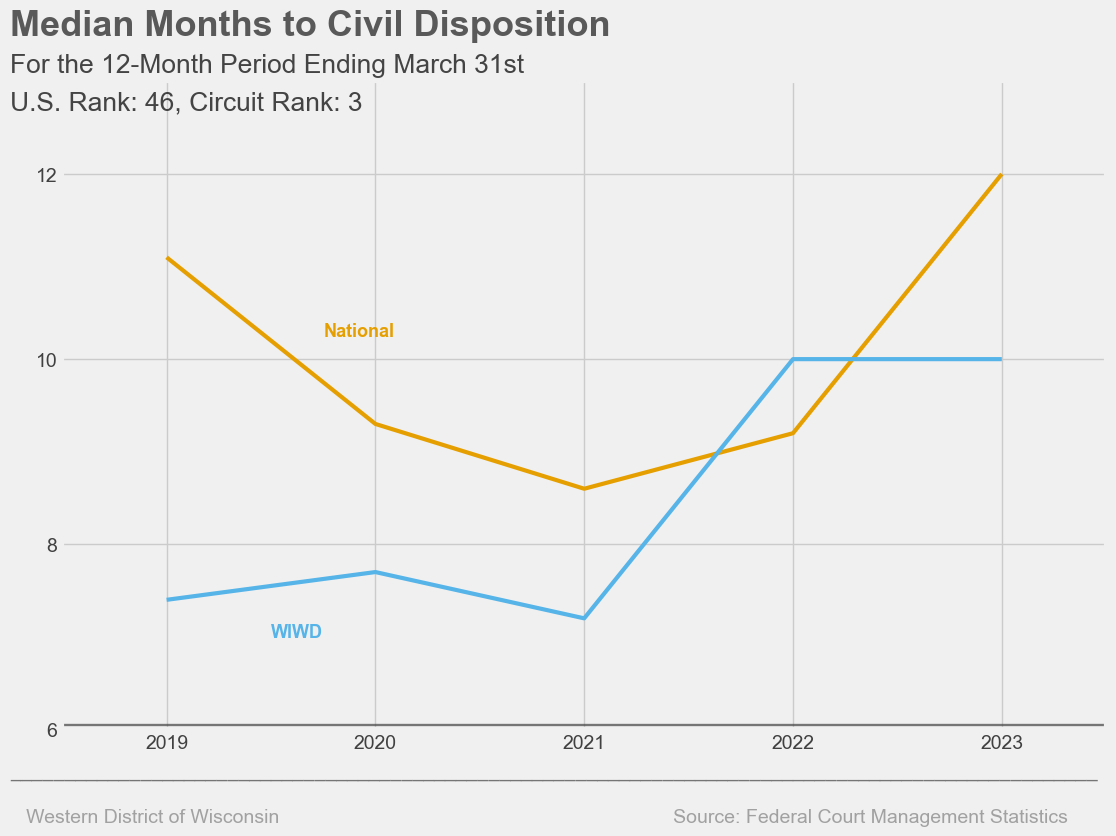

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
style.use('fivethirtyeight')

ax1 = sns.lineplot(x=df1.index, y=nat, color=colors[1], linewidth=3)
ax2 = sns.lineplot(x=df1.index, y=wiwd, color=colors[2], linewidth=3)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)

plt.xlim(2018.5, 2023.5)
plt.ylim(6, 13)
ax.axhline(y=6.05, color='#414141', linewidth=1.7, alpha=.7)
ax.yaxis.label.set_visible(False)

# Y-labels to only these
ax.set_yticks([ 6, 8, 10, 12])
ax.set_yticklabels(labels=[ '6','8', '10', '12' ], fontsize=14, color='#414141')



# X-labels and changing label names
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.set_xticklabels([2019, 2020, 2021, 2022, 2023], fontsize=14, color='#414141')
# plt.xlim(left=2018, right=2024)
#
# # Title and Subtitle
ax.text(x=2018.25, y=13.5, s="Median Months to Civil Disposition", fontsize=26, weight='bold', alpha=.75)
ax.text(x=2018.25, y=13.1, s="For the 12-Month Period Ending March 31st", fontsize=19, alpha=.85)
ax.text(x=2018.25, y=12.7, s="U.S. Rank: 46, Circuit Rank: 3", fontsize=19, alpha=.85)

# # Text labels for each plotted line
ax.text(x=2019.5, y=7, s="WIWD", fontsize=13, fontweight='semibold', color=colors[2])
ax.text(x=2019.75, y=10.25, s="National", fontsize=13, fontweight='semibold', color=colors[1])

#
# # Signature bar
ax.text(x=2018.25, y=5.5,
        s='____________________________________________________________________________________________________',
        color='#414141', alpha=.7)
# # # Footer
ax.text(x=2018.25, y=5,
        s='   Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)

ax.text(x=2021.35, y=5,
        s='   Source: Federal Court Management Statistics', fontsize=14, color='grey', alpha=.7);

plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/median months to disposition.png', dpi=300, bbox_inches='tight', transparent=False)

In [39]:
data = [(27.5, 22.6), (28.6, 24.3), (26.1, 24.3), (32.6, 24.4), (35.0, 24.5)]
columns = ['National', 'WIWD']
index = [2019, 2020, 2021, 2022, 2023]

In [40]:
df2 = pd.DataFrame(data=data, columns=columns, index=index)

In [41]:
nat = df2['National']
wiwd = df2['WIWD']

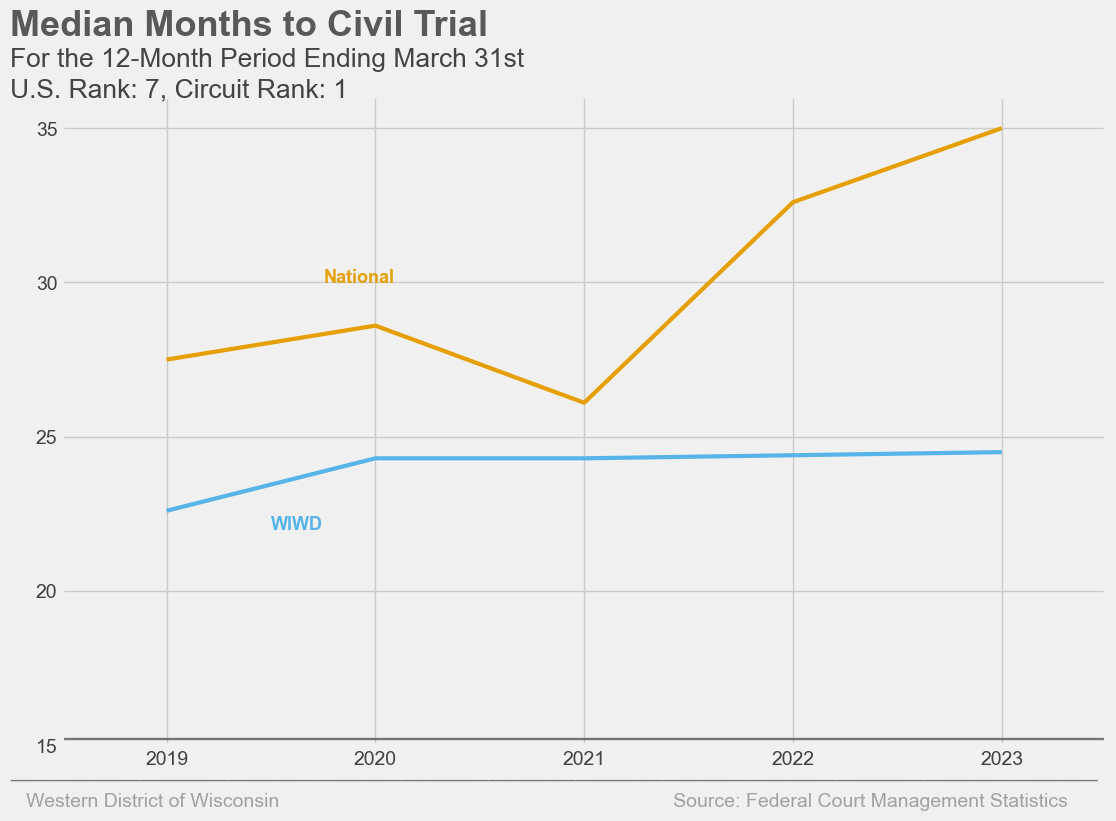

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
style.use('fivethirtyeight')

ax1 = sns.lineplot(x=df2.index, y=nat, color=colors[1], linewidth=3)
ax2 = sns.lineplot(x=df2.index, y=wiwd, color=colors[2], linewidth=3)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)


plt.ylim(15, 36)
plt.xlim(2018.5, 2023.5)
ax.axhline(y=15.2, color='#414141', linewidth=1.7, alpha=.7)
ax.yaxis.label.set_visible(False)

# Y-labels to only these
ax.set_yticks([15, 20, 25, 30, 35])
ax.set_yticklabels(labels=['15','20','25','30','35'], fontsize=14, color='#414141')

# X-labels and changing label names
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.set_xticklabels([2019, 2020, 2021, 2022, 2023], fontsize=14, color='#414141')
# plt.xlim(left=2018, right=2024)
#
# # Title and Subtitle
ax.text(x=2018.25, y=38, s="Median Months to Civil Trial", fontsize=26, weight='bold', alpha=.75)
ax.text(x=2018.25, y=37, s="For the 12-Month Period Ending March 31st", fontsize=19, alpha=.85)
ax.text(x=2018.25, y=36, s="U.S. Rank: 7, Circuit Rank: 1", fontsize=19, alpha=.85)


# # Text labels for each plotted line
ax.text(x=2019.5, y=22, s="WIWD", fontsize=13, fontweight='semibold', color=colors[2])
ax.text(x=2019.75, y=30, s="National", fontsize=13, fontweight='semibold', color=colors[1])
#
# # Signature bar
ax.text(x=2018.25, y=14,
        s='____________________________________________________________________________________________________',
        color='#414141', alpha=.7)
# # # Footer
ax.text(x=2018.25, y=13,
        s='   Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)

ax.text(x=2021.35, y=13,
        s='   Source: Federal Court Management Statistics', fontsize=14, color='grey', alpha=.7);

plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/median months to civil trial.png', dpi=300, bbox_inches='tight', transparent=False)


In [43]:
data = [(6.9, 7.2), (6.7, 7.3), (9.2, 8.6), (10.4, 9.2), (11.0, 9.6)]
columns = ['National', 'WIWD']
index = [2019, 2020, 2021, 2022, 2023]

In [44]:
df3 = pd.DataFrame(data=data, columns=columns, index=index)
nat = df3['National']
wiwd = df3['WIWD']

In [45]:
df3


,National,WIWD
2019,6.9,7.2
2020,6.7,7.3
2021,9.2,8.6
2022,10.4,9.2
2023,11.0,9.6


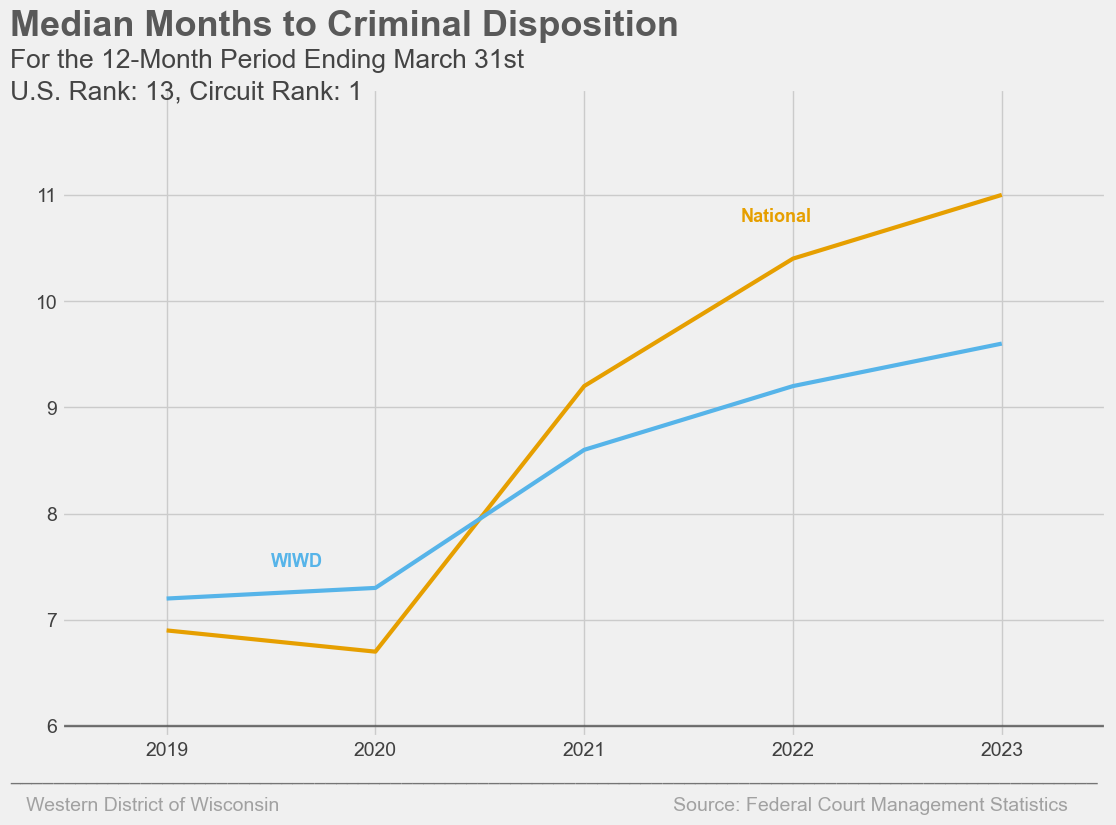

In [46]:
fig, ax = plt.subplots(figsize=(12, 8))
style.use('fivethirtyeight')

ax1 = sns.lineplot(x=df3.index, y=nat, color=colors[1], linewidth=3)
ax2 = sns.lineplot(x=df3.index, y=wiwd, color=colors[2], linewidth=3)

ax.tick_params(axis = 'both', which = 'major', labelsize = 14)


plt.ylim(5.9, 12)
plt.xlim(2018.5, 2023.5)
ax.axhline(y=6.0, color='#414141', linewidth=1.7, alpha=.7)
ax.yaxis.label.set_visible(False)
#
# # Y-labels to only these
ax.set_yticks([6, 7, 8, 9, 10, 11])
ax.set_yticklabels(labels=['6','7','8','9','10','11'], fontsize=14, color='#414141')

# # X-labels and changing label names
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.set_xticklabels([2019, 2020, 2021, 2022, 2023], fontsize=14, color='#414141')
# # plt.xlim(left=2018, right=2024)
# #
# # # Title and Subtitle
ax.text(x=2018.25, y=12.5, s="Median Months to Criminal Disposition", fontsize=26, weight='bold', alpha=.75)
ax.text(x=2018.25, y=12.2, s="For the 12-Month Period Ending March 31st", fontsize=19, alpha=.85)
ax.text(x=2018.25, y=11.9, s="U.S. Rank: 13, Circuit Rank: 1", fontsize=19, alpha=.85)
#
#
# # # Text labels for each plotted line
ax.text(x=2019.5, y=7.5, s="WIWD", fontsize=13, fontweight='semibold', color=colors[2])
ax.text(x=2021.75, y=10.75, s="National", fontsize=13, fontweight='semibold', color=colors[1])
#
# # # Signature bar
ax.text(x=2018.25, y=5.5,
        s='____________________________________________________________________________________________________',
        color='#414141', alpha=.7)
# # # # Footer
ax.text(x=2018.25, y=5.2,
        s='   Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)

ax.text(x=2021.35, y=5.2,
        s='   Source: Federal Court Management Statistics', fontsize=14, color='grey', alpha=.7);

plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/median months to criminal disposition.png', dpi=300, bbox_inches='tight', transparent=False)


In [47]:
data = [187, 187,145,156,133]
columns = ['WIWD']
index = [2019, 2020, 2021, 2022, 2023]

In [48]:
df4 = pd.DataFrame(data=data, columns=columns, index=index)

In [49]:
df4

,WIWD
2019,187
2020,187
2021,145
2022,156
2023,133


In [50]:
x = df4['WIWD']
y = df4.index

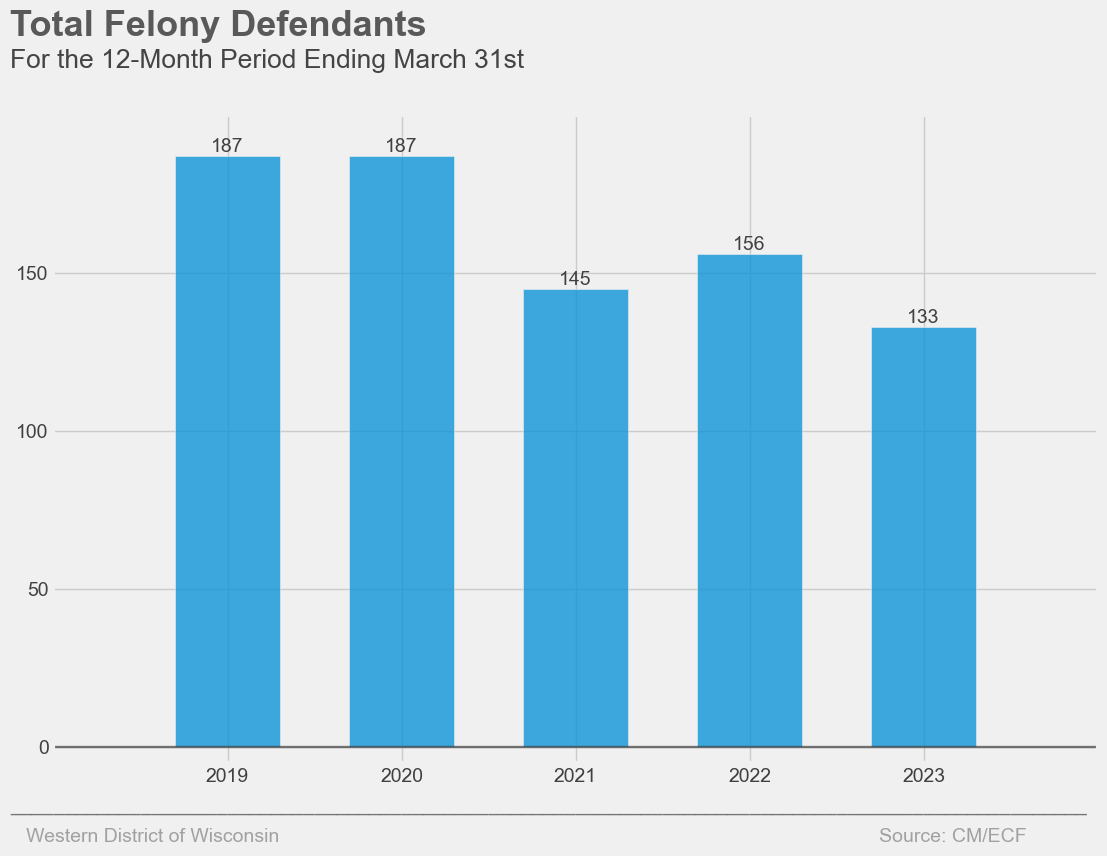

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
style.use('fivethirtyeight')
bar_width = 0.6
for (total, year) in zip(x, y):
    p = ax.bar(year,
               # using the Case ID data
               total,
               # set the width
               width=bar_width,
               # with the label Case Year
               label=year,
               # with alpha 0.5
               alpha=0.8,
               # with color
               color='#0F95D7')
    ax.bar_label(p, label_type='edge', fontsize=14, color='#414141')
# # Y axis past 0 & above 100 -- grid line will pass 0 & 100 marker
plt.ylim(-5, 200)
# # Bolded horizontal line at y=0
ax.axhline(y=0, color='#414141', linewidth=1.7, alpha=.7)
# # create more vertical space
plt.xlim(left=2018, right=2024)
#
# # Y-labels to only these
ax.set_yticks([0, 50, 100, 150])
ax.set_yticklabels(labels=['0','50','100','150'], fontsize=14, color='#414141')
#
# # X-labels and changing label names
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.set_xticklabels(['2019', '2020', '2021', '2022', '2023'], fontsize=14, color='#414141')
#
# # create more vertical space
# plt.xlim(left=2018)
#
# # Title and Subtitle
ax.text(x=2017.75, y=225, s="Total Felony Defendants", fontsize=26, weight='bold', alpha=.75)
ax.text(x=2017.75, y=215, s="For the 12-Month Period Ending March 31st", fontsize=19, alpha=.85)

# # Signature bar
ax.text(x=2017.75, y=-20,
        s='___________________________________________________________________________________________________',
        color='#414141', alpha=.7)
# # Footer
ax.text(x=2017.75, y=-30,
        s='   Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)
#
ax.text(x=2022.65, y=-30,
        s='   Source: CM/ECF', fontsize=14, color='grey', alpha=.7);
plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/total_criminal defendants.png', dpi=300, bbox_inches='tight', transparent=False)


In [73]:
input_file = Path.cwd() / 'data_files' / 'wdba_stats_processed_Jun-07-23.csv'

In [249]:
df = pd.read_csv(input_file, parse_dates=['date_filed', "date_reopened", "date_terminated"],
                 dtype={'group': 'category', 'is_prose': 'category'})


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4784 entries, 0 to 4783
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   case_number       4784 non-null   object        
 1   judge             4784 non-null   object        
 2   date_filed        4784 non-null   datetime64[ns]
 3   date_reopened     87 non-null     datetime64[ns]
 4   date_terminated   4136 non-null   datetime64[ns]
 5   NOS               4784 non-null   int64         
 6   IsProse           4784 non-null   object        
 7   group             4784 non-null   category      
 8   is_prose          4784 non-null   category      
 9   statistical_year  4784 non-null   int64         
dtypes: category(2), datetime64[ns](3), int64(2), object(3)
memory usage: 309.3+ KB


In [55]:
case_breakdown_pro_se_vs_counseled= pd.crosstab(df['statistical_year'],
            df['is_prose'],
            aggfunc='count',
            values=df['case_number'],
            margins=True,
            margins_name='Total',
           )

In [56]:
case_percentage_pro_se_vs_counseled=pd.crosstab(df['statistical_year'],
            df['is_prose'],
            aggfunc='count',
            values=df['case_number'],
            margins=True,
            margins_name='Total',
           normalize='index'
           )

In [57]:
case_percentage_pro_se_vs_counseled=pd.crosstab(df['statistical_year'],
            df['is_prose'],
            aggfunc='count',
            values=df['case_number'],
           normalize='index'
           )


In [58]:
case_percentage_pro_se_vs_counseled=round(case_percentage_pro_se_vs_counseled.loc[:, :] * 100, 1)

In [59]:
case_percentage_pro_se_vs_counseled

is_prose,counseled,prose
statistical_year,,
2019,60.8,39.2
2020,57.2,42.8
2021,65.6,34.4
2022,58.0,42.0
2023,53.0,47.0


In [60]:
counseled = case_percentage_pro_se_vs_counseled['counseled']
prose = case_percentage_pro_se_vs_counseled['prose']
y = case_percentage_pro_se_vs_counseled.index

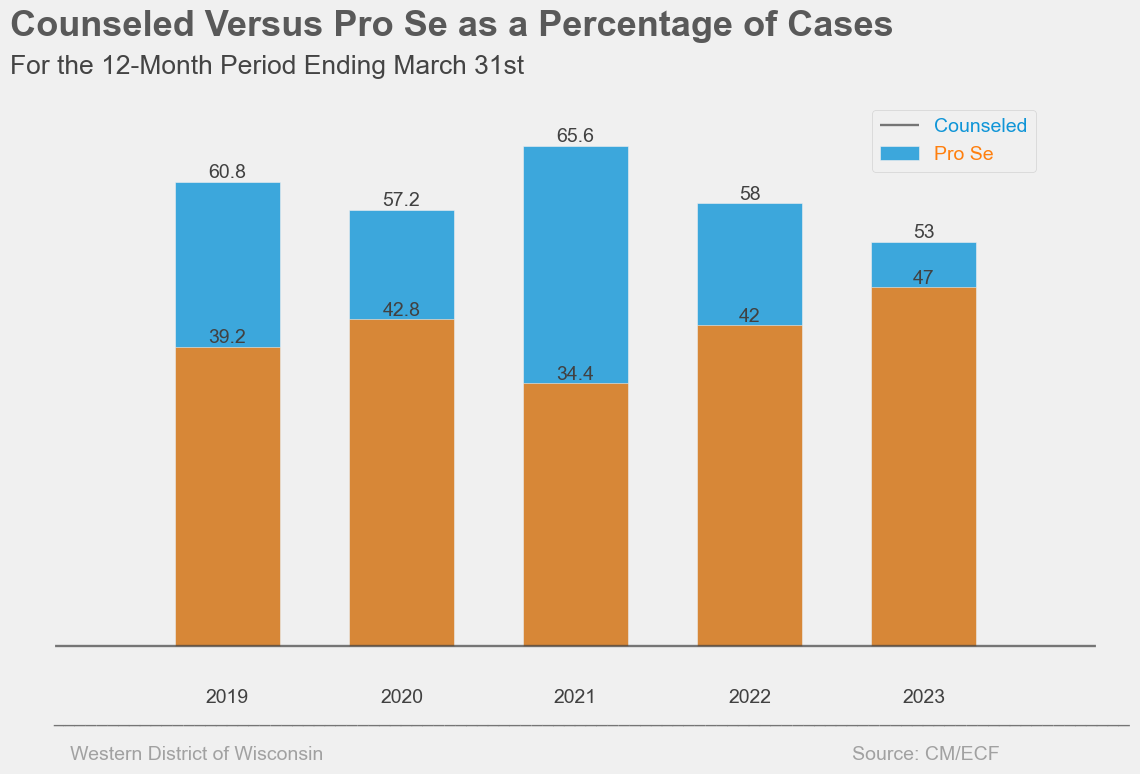

In [61]:
counseled = case_percentage_pro_se_vs_counseled['counseled']
prose = case_percentage_pro_se_vs_counseled['prose']
y = case_percentage_pro_se_vs_counseled.index

fig, ax = plt.subplots(figsize=(12, 8))
style.use('fivethirtyeight')
bar_width = 0.6
for (counseled, prose, year) in zip(counseled, prose, y):
    p = ax.bar(year,
               # using the Case ID data
               counseled,
               # set the width
               width=bar_width,
               # with the label Case Year
               label=year,
               # with alpha 0.5
               alpha=0.8,
               # with color
               color='#0F95D7')
    ax.bar_label(p, label_type='edge', fontsize=14, color='#414141')

    p = ax.bar(year,
               # using the Case ID data
               prose,
               # set the width
               width=bar_width,
               # with the label Case Year
               label=year,
               # with alpha 0.5
               alpha=0.8,
               # with color
               color='#FF7F0E')
    ax.bar_label(p, label_type='edge', fontsize=14, color='#414141')
ax.tick_params(axis = 'both', which = 'major', labelsize = 14, grid_alpha=0)
plt.ylim(-5, 80)
# # # Bolded horizontal line at y=0
ax.axhline(y=0, color='#414141', linewidth=1.7, alpha=.7)
# # # create more vertical space
plt.xlim(left=2018, right=2024)
# #
# # # Y-labels to only these
ax.set_yticks([])
ax.set_yticklabels(labels=[], fontsize=14, color='#414141')
# #
# # # X-labels and changing label names
ax.set_xticks([2019, 2020, 2021, 2022, 2023])
ax.set_xticklabels(['2019', '2020', '2021', '2022', '2023'], fontsize=14, color='#414141')

# Legend
ax.legend(['Counseled', 'Pro Se'], fontsize=14,  bbox_to_anchor=(0.95, .9), labelcolor=['#0F95D7', '#FF7F0E'])
# # Title and Subtitle
ax.text(x=2017.75, y=80, s="Counseled Versus Pro Se as a Percentage of Cases", fontsize=26, weight='bold', alpha=.75)
ax.text(x=2017.75, y=75, s="For the 12-Month Period Ending March 31st", fontsize=19, alpha=.85)

# # Signature bar
ax.text(x=2018, y=-10,
        s='___________________________________________________________________________________________________',
        color='#414141', alpha=.7)
# # Footer
ax.text(x=2018, y=-15,
        s='   Western District of Wisconsin', fontsize=14, color='grey', alpha=.7)
#
ax.text(x=2022.5, y=-15,
        s='   Source: CM/ECF', fontsize=14, color='grey', alpha=.7);
plt.savefig('/Users/jwt/PycharmProjects/cpi_program/WDBA2023/figures/counseled vs prose.png', dpi=300, bbox_inches='tight', transparent=False)

In [251]:
df['group'] = df['group'].apply(lambda x: 'Prisoner Petitions' if x == 'Habeas Corpus' else x)
df['group'] = df['group'].apply(lambda x: 'Torts/Personal Injury' if x == 'Personal Property' else x)

In [252]:
df.describe()

,NOS,statistical_year
count,4784.000000,4784.000000
mean,562.847199,2020.817935
std,195.486111,1.381792
min,110.000000,2019.000000
25%,442.000000,2020.000000
50%,550.000000,2021.000000
75%,751.000000,2022.000000
max,950.000000,2023.000000


In [192]:
nos_totals_by_year = pd.crosstab(df['group'],
                                 df['statistical_year'],
                                 aggfunc='count',
                                 values=df['case_number'],
                                 margins=False)


In [193]:
nos_totals_by_year

statistical_year,2019,2020,2021,2022,2023
group,,,,,
Bankruptcy,4.0,4.0,4.0,5.0,4.0
Civil Rights,134.0,135.0,135.0,133.0,145.0
Contract,58.0,71.0,53.0,52.0,49.0
Federal Tax Suits,11.0,6.0,2.0,3.0,7.0
Forfeiture/Penalty,4.0,4.0,7.0,5.0,7.0
Immigration,2.0,2.0,NaN,8.0,9.0
Intellectual Property Rights,44.0,49.0,36.0,29.0,28.0
Labor,75.0,69.0,64.0,51.0,51.0
Other Statutes,118.0,137.0,146.0,88.0,46.0


In [186]:
nos_totals_by_year.index

Index(['Civil Rights', 'Intellectual Property Rights'], dtype='object', name='group')

In [194]:
nos_totals_by_year = nos_totals_by_year.loc[['Civil Rights','Intellectual Property Rights','Labor', 'Other Statutes', 'Prisoner Petitions', 'Social Security', 'Torts/Personal Injury'], [2020,2023]]

In [195]:
nos_totals_by_year.head(15)

statistical_year,2020,2023
group,,
Civil Rights,135.0,145.0
Intellectual Property Rights,49.0,28.0
Labor,69.0,51.0
Other Statutes,137.0,46.0
Prisoner Petitions,399.0,271.0
Social Security,143.0,94.0
Torts/Personal Injury,76.0,55.0


In [119]:
percentage_change = nos_totals_by_year.pct_change(axis='columns')

In [120]:
percentage_change_2023 = percentage_change[2023]

In [123]:
round(percentage_change_2023 *100,2)

group
Bankruptcy                        0.00
Civil Rights                      7.41
Contract                        -30.99
Federal Tax Suits                16.67
Forfeiture/Penalty               75.00
Immigration                     350.00
Intellectual Property Rights    -42.86
Labor                           -26.09
Other Statutes                  -66.42
Prisoner Petitions              -32.08
Real Property                    44.44
Social Security                 -34.27
Torts/Personal Injury           -27.63
Name: 2023, dtype: float64

In [124]:
nos_totals_by_year['percentage_change'] = round(percentage_change_2023 *100,2)


In [71]:
nos_totals_by_year.sort_values(index, ascending=False, inplace=True)

/var/folders/9d/l9hqp1614q7cnmmrcz89glp80000gn/T/ipykernel_58740/2512412199.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  nos_totals_by_year.sort_values(index, ascending=False, inplace=True)


TypeError: unhashable type: 'list'

In [196]:
nos_totals_by_year

statistical_year,2020,2023
group,,
Civil Rights,135.0,145.0
Intellectual Property Rights,49.0,28.0
Labor,69.0,51.0
Other Statutes,137.0,46.0
Prisoner Petitions,399.0,271.0
Social Security,143.0,94.0
Torts/Personal Injury,76.0,55.0


In [128]:
nos_totals_by_year.sort_values("percentage_change", ascending=True, inplace=True)

In [208]:
nos_totals_by_year

statistical_year,2020,2023
group,,
Civil Rights,135.0,145.0
Intellectual Property Rights,49.0,28.0
Labor,69.0,51.0
Other Statutes,137.0,46.0
Prisoner Petitions,399.0,271.0
Social Security,143.0,94.0
Torts/Personal Injury,76.0,55.0


In [207]:
ct = pd.crosstab(nos_totals_by_year['statistrical_year'],
                                 nos_totals_by_year.index,
                                 normalize='index')


KeyError: 'statistrical_year'

In [248]:
df

,case_number,judge,date_filed,date_reopened,date_terminated,NOS,IsProse,group,is_prose,statistical_year
0,3:18-cv-00232-bbc,bbc,2018-04-02,NaT,2018-05-02,550,y,Prisoner Petitions,prose,2019
1,3:18-cv-00231-jdp,jdp,2018-04-02,NaT,2019-02-21,440,y,Civil Rights,prose,2019
2,3:18-cv-00234-jdp,jdp,2018-04-02,NaT,2018-04-23,530,y,Prisoner Petitions,prose,2019
3,3:18-cv-00233-bbc,bbc,2018-04-03,NaT,2018-07-18,864,n,Social Security,counseled,2019
4,3:18-cv-00235-wmc,wmc,2018-04-04,NaT,2019-09-25,791,y,Labor,prose,2019
...,...,...,...,...,...,...,...,...,...,...
4779,3:17-cv-00435-wmc,wmc,2017-06-05,2021-04-08,2022-06-22,540,n,Prisoner Petitions,counseled,2022
4780,3:17-cv-00552-wmc,wmc,2017-07-17,2021-05-06,2022-08-18,550,y,Prisoner Petitions,prose,2022
4781,3:17-cv-00231-bbc,bbc,2017-03-22,2021-06-02,2021-06-02,530,n,Prisoner Petitions,counseled,2022
4782,3:17-cv-00524-wmc,wmc,2017-07-06,2021-07-08,2022-04-28,550,y,Prisoner Petitions,prose,2022


In [233]:
# df1= df.loc[df['group'].isin(['Civil Rights','Intellectual Property Rights','Labor', 'Other Statutes', 'Prisoner Petitions', 'Social Securit|y', 'Torts/Personal Injury'])]



In [253]:
df['group'].nunique()

13

In [260]:
df1= df.loc[df['statistical_year'].isin([2020,2023])]

In [261]:
df1['group'].nunique()

13

In [265]:
df1.pct_change(axis='columns')

TypeError: cannot perform __truediv__ with this index type: DatetimeArray

In [269]:
ct = pd.crosstab(df1['group'], df1['statistical_year'],
                                 )

In [270]:
ct

statistical_year,2020,2023
group,,
Bankruptcy,4,4
Civil Rights,135,145
Contract,71,49
Federal Tax Suits,6,7
Forfeiture/Penalty,4,7
Immigration,2,9
Intellectual Property Rights,49,28
Labor,69,51
Other Statutes,137,46


In [273]:
ct.pct_change(axis='columns').mul(100),round(2)

(statistical_year              2020        2023
 group                                         
 Bankruptcy                     NaN    0.000000
 Civil Rights                   NaN    7.407407
 Contract                       NaN  -30.985915
 Federal Tax Suits              NaN   16.666667
 Forfeiture/Penalty             NaN   75.000000
 Immigration                    NaN  350.000000
 Intellectual Property Rights   NaN  -42.857143
 Labor                          NaN  -26.086957
 Other Statutes                 NaN  -66.423358
 Prisoner Petitions             NaN  -32.080201
 Real Property                  NaN   44.444444
 Social Security                NaN  -34.265734
 Torts/Personal Injury          NaN  -27.631579,
 2)

/var/folders/9d/l9hqp1614q7cnmmrcz89glp80000gn/T/ipykernel_58740/1274910193.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')


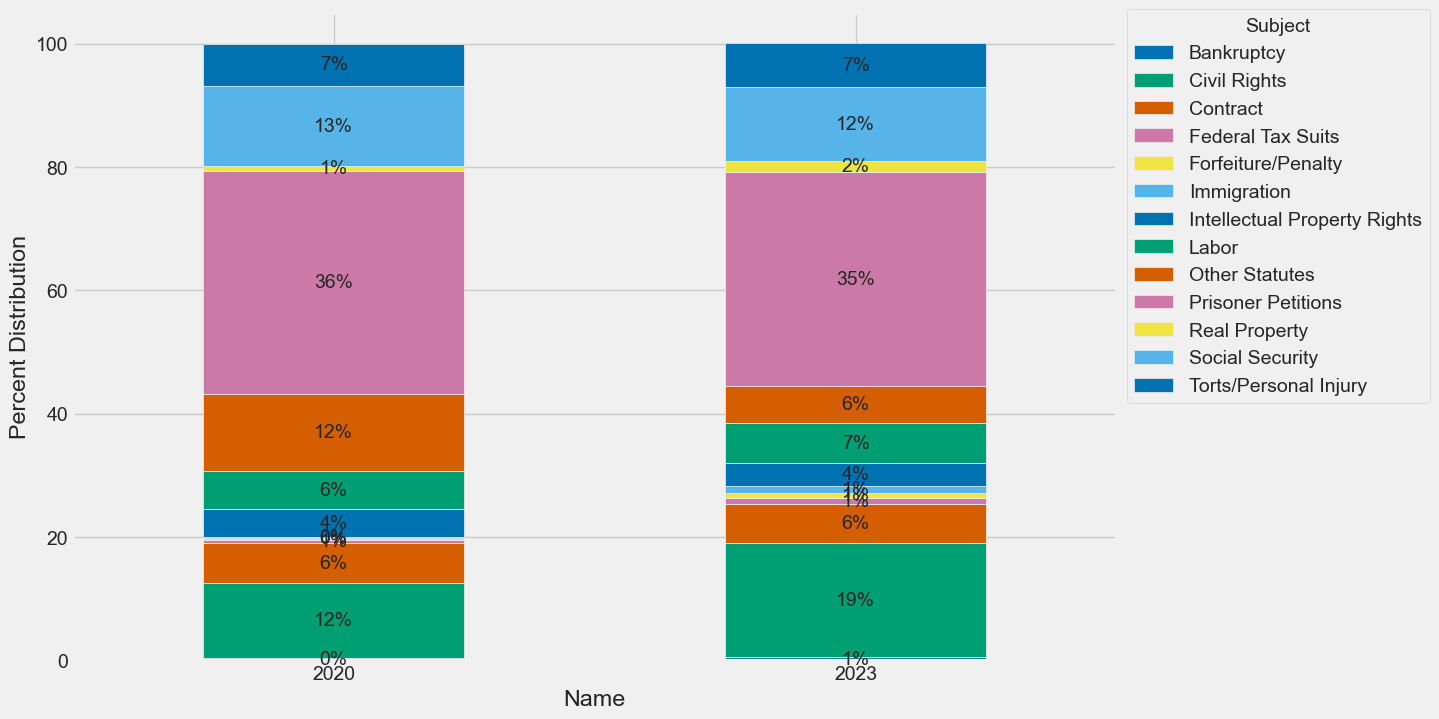

In [264]:
import matplotlib.pyplot as plt
style.use('seaborn-colorblind')
ax = ct.plot(kind='bar', figsize=(12, 8), stacked=True, rot=0, xlabel='Name', ylabel='Percent Distribution')
ax.legend(title='Subject', bbox_to_anchor=(1, 1.02), loc='upper left')
for c in ax.containers:

    # add the annotations
    ax.bar_label(c, fmt='%0.0f%%', label_type='center')